## ppigeniepath

In [7]:
%%time
%run ./examples/geniepath

Epoch: 01, Loss: 0.5654, Val: 0.4738, Test: 0.4750
Epoch: 02, Loss: 0.5252, Val: 0.5341, Test: 0.5384
Epoch: 03, Loss: 0.5121, Val: 0.5104, Test: 0.5169
Epoch: 04, Loss: 0.4911, Val: 0.5489, Test: 0.5567
Epoch: 05, Loss: 0.4697, Val: 0.5833, Test: 0.5936
Epoch: 06, Loss: 0.4424, Val: 0.6215, Test: 0.6351
Epoch: 07, Loss: 0.4154, Val: 0.6511, Test: 0.6691
Epoch: 08, Loss: 0.3841, Val: 0.6382, Test: 0.6561
Epoch: 09, Loss: 0.3650, Val: 0.6866, Test: 0.7067
Epoch: 10, Loss: 0.3293, Val: 0.7163, Test: 0.7384
Epoch: 11, Loss: 0.2928, Val: 0.7477, Test: 0.7719
Epoch: 12, Loss: 0.2829, Val: 0.7603, Test: 0.7806
Epoch: 13, Loss: 0.2603, Val: 0.8044, Test: 0.8272
Epoch: 14, Loss: 0.2238, Val: 0.8225, Test: 0.8452
Epoch: 15, Loss: 0.2050, Val: 0.8291, Test: 0.8524
Epoch: 16, Loss: 0.1960, Val: 0.8458, Test: 0.8689
Epoch: 17, Loss: 0.1966, Val: 0.8306, Test: 0.8567
Epoch: 18, Loss: 0.1870, Val: 0.8486, Test: 0.8697
Epoch: 19, Loss: 0.1956, Val: 0.8590, Test: 0.8820
Epoch: 20, Loss: 0.1762, Val: 0

## sgeniepath v1

Epoch: 01, Loss: 0.5771, Val: 0.4285, Test: 0.4302
Epoch: 02, Loss: 0.5351, Val: 0.5369, Test: 0.5420
Epoch: 03, Loss: 0.5103, Val: 0.5219, Test: 0.5301
Epoch: 04, Loss: 0.4663, Val: 0.6091, Test: 0.6199
Epoch: 05, Loss: 0.4234, Val: 0.6461, Test: 0.6605
Epoch: 06, Loss: 0.3701, Val: 0.7052, Test: 0.7213
Epoch: 07, Loss: 0.3181, Val: 0.7397, Test: 0.7589
Epoch: 08, Loss: 0.2631, Val: 0.8044, Test: 0.8243
Epoch: 09, Loss: 0.2118, Val: 0.8390, Test: 0.8605
Epoch: 10, Loss: 0.1693, Val: 0.8770, Test: 0.8967
Epoch: 11, Loss: 0.1351, Val: 0.8980, Test: 0.9176
Epoch: 12, Loss: 0.1087, Val: 0.9171, Test: 0.9364
Epoch: 13, Loss: 0.0885, Val: 0.9284, Test: 0.9466
Epoch: 14, Loss: 0.0747, Val: 0.9383, Test: 0.9557
Epoch: 15, Loss: 0.0627, Val: 0.9445, Test: 0.9599
Epoch: 16, Loss: 0.0552, Val: 0.9497, Test: 0.9645
Epoch: 17, Loss: 0.0488, Val: 0.9538, Test: 0.9680
Epoch: 18, Loss: 0.0445, Val: 0.9539, Test: 0.9681
Epoch: 19, Loss: 0.0402, Val: 0.9572, Test: 0.9708
Epoch: 20, Loss: 0.0370, Val: 0

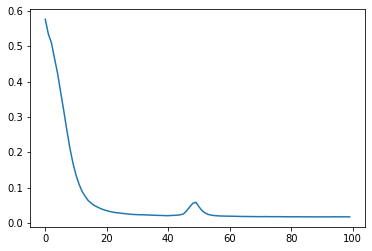

CPU times: user 39min 5s, sys: 3min 9s, total: 42min 14s
Wall time: 2min 43s


In [3]:
%%time
%matplotlib inline
import argparse
import os.path as osp

import torch
from torch_geometric.datasets import PPI
from torch_geometric.data import DataLoader
from torch_geometric.nn import GATConv
from torch_geometric.nn import AGNNConv

from sklearn.metrics import f1_score

# parser = argparse.ArgumentParser()
# parser.add_argument('--model', type=str, default='GeniePathLazy')
# args = parser.parse_args()
# assert args.model in ['GeniePath', 'GeniePathLazy']

path = osp.join('./', 'data', 'PPI')
train_dataset = PPI(path, split='train')
val_dataset = PPI(path, split='val')
test_dataset = PPI(path, split='test')
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

dim = 256
lstm_hidden = 256
layer_num = 4

class agnnn(torch.nn.Module):
    def __init__(self,in_dim,out_dim):
        super(agnnn, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, 16)
        self.prop1 = AGNNConv(requires_grad=False)
        self.prop2 = AGNNConv(requires_grad=True)
        self.lin2 = torch.nn.Linear(16, out_dim)

    def forward(self):
        x = F.dropout(data.x, training=self.training)
        x = F.relu(self.lin1(x))
        x = self.prop1(x, edge_index)
        x = self.prop2(x, edge_index)
        x = F.dropout(x, training=self.training)
        x = self.lin2(x)
        return x
        
class Breadth(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Breadth, self).__init__()
        self.gatconv = AGNNConv(requires_grad=True)

    def forward(self, x, edge_index):
        x = torch.tanh(self.gatconv(x, edge_index))
        return x



class Depth(torch.nn.Module):
    def __init__(self, in_dim, hidden):
        super(Depth, self).__init__()
        self.lstm = torch.nn.LSTM(in_dim, hidden, 1, bias=False)

    def forward(self, x, h, c):
        x, (h, c) = self.lstm(x, (h, c))
        return x, (h, c)


class GeniePathLayer(torch.nn.Module):
    def __init__(self, in_dim):
        super(GeniePathLayer, self).__init__()
        self.breadth_func = Breadth(in_dim, dim)
        self.depth_func = Depth(dim, lstm_hidden)

    def forward(self, x, edge_index, h, c):
        x = self.breadth_func(x, edge_index)
        x = x[None, :]
        x, (h, c) = self.depth_func(x, h, c)
        x = x[0]
        return x, (h, c)


class GeniePath(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePath, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.gplayers = torch.nn.ModuleList(
            [GeniePathLayer(dim) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        for i, l in enumerate(self.gplayers):
            x, (h, c) = self.gplayers[i](x, edge_index, h, c)
        x = self.lin2(x)
        return x


class GeniePathLazy(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePathLazy, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.breadths = torch.nn.ModuleList(
            [Breadth(dim, dim) for i in range(layer_num)])
        self.depths = torch.nn.ModuleList(
            [Depth(dim * 2, lstm_hidden) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        h_tmps = []
        for i, l in enumerate(self.breadths):
            h_tmps.append(self.breadths[i](x, edge_index))
        x = x[None, :]
        for i, l in enumerate(self.depths):
            in_cat = torch.cat((h_tmps[i][None, :], x), -1)
            x, (h, c) = self.depths[i](in_cat, h, c)
        x = self.lin2(x[0])
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kwargs = {'GeniePath': GeniePath, 'GeniePathLazy': GeniePathLazy}
model = GeniePathLazy(train_dataset.num_features,
                           train_dataset.num_classes).to(device)
loss_op = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        num_graphs = data.num_graphs
        data.batch = None
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_op(model(data.x, data.edge_index), data.y)
        total_loss += loss.item() * num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)


def test(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        with torch.no_grad():
            out = model(data.x.to(device), data.edge_index.to(device))
        preds.append((out > 0).float().cpu())

    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

losslist=[]

for epoch in range(1, 101):
    loss = train()
    losslist.append(loss)
    val_f1 = test(val_loader)
    test_f1 = test(test_loader)
    print('Epoch: {:02d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'.format(
        epoch, loss, val_f1, test_f1))
from matplotlib import pyplot as plt 
%matplotlib inline

plt.plot(losslist)
plt.show()

In [ ]:
loss=[1,2,3,4]
from matplotlib import pyplot as plt 
%matplotlib inline

plt.plot(loss)
plt.show()

## sgeniepath v2 不加dropout

In [9]:
%%time
import argparse
import os.path as osp

import torch
from torch_geometric.datasets import PPI
from torch_geometric.data import DataLoader
from torch_geometric.nn import GATConv
from torch_geometric.nn import AGNNConv
import torch.nn.functional as F
from sklearn.metrics import f1_score

# parser = argparse.ArgumentParser()
# parser.add_argument('--model', type=str, default='GeniePathLazy')
# args = parser.parse_args()
# assert args.model in ['GeniePath', 'GeniePathLazy']

path = osp.join('./', 'data', 'PPI')
train_dataset = PPI(path, split='train')
val_dataset = PPI(path, split='val')
test_dataset = PPI(path, split='test')
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

dim = 256
lstm_hidden = 256
layer_num = 4

# class agnnn(torch.nn.Module):
#     def __init__(self,in_dim,out_dim):
#         super(agnnn, self).__init__()
#         self.lin1 = torch.nn.Linear(in_dim, 16)
#         self.prop1 = AGNNConv(requires_grad=False)
#         self.prop2 = AGNNConv(requires_grad=True)
#         self.lin2 = torch.nn.Linear(16, out_dim)

#     def forward(self):
#         x = F.dropout(data.x, training=self.training)
#         x = F.relu(self.lin1(x))
#         x = self.prop1(x, edge_index)
#         x = self.prop2(x, edge_index)
#         x = F.dropout(x, training=self.training)
#         x = self.lin2(x)
#         return x
        
class Breadth(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Breadth, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, 16)
        self.prop1 = AGNNConv(requires_grad=False)
        self.prop2 = AGNNConv(requires_grad=True)
        self.lin2 = torch.nn.Linear(16, out_dim)
        # self.gatconv = AGNNConv(requires_grad=True)

    def forward(self, x, edge_index):
#         x = F.dropout(x, training=self.training)
        x = F.relu(self.lin1(x))
        x = self.prop1(x, edge_index)
        x = self.prop2(x, edge_index)
#         x = F.dropout(x, training=self.training)
        x = self.lin2(x)
        # x = torch.tanh(self.gatconv(x, edge_index))
        x = torch.tanh(x)
        return x



class Depth(torch.nn.Module):
    def __init__(self, in_dim, hidden):
        super(Depth, self).__init__()
        self.lstm = torch.nn.LSTM(in_dim, hidden, 1, bias=False)

    def forward(self, x, h, c):
        x, (h, c) = self.lstm(x, (h, c))
        return x, (h, c)


class GeniePathLayer(torch.nn.Module):
    def __init__(self, in_dim):
        super(GeniePathLayer, self).__init__()
        self.breadth_func = Breadth(in_dim, dim)
        self.depth_func = Depth(dim, lstm_hidden)

    def forward(self, x, edge_index, h, c):
        x = self.breadth_func(x, edge_index)
        x = x[None, :]
        x, (h, c) = self.depth_func(x, h, c)
        x = x[0]
        return x, (h, c)


class GeniePath(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePath, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.gplayers = torch.nn.ModuleList(
            [GeniePathLayer(dim) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        for i, l in enumerate(self.gplayers):
            x, (h, c) = self.gplayers[i](x, edge_index, h, c)
        x = self.lin2(x)
        return x


class GeniePathLazy(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePathLazy, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.breadths = torch.nn.ModuleList(
            [Breadth(dim, dim) for i in range(layer_num)])
        self.depths = torch.nn.ModuleList(
            [Depth(dim * 2, lstm_hidden) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        h_tmps = []
        for i, l in enumerate(self.breadths):
            h_tmps.append(self.breadths[i](x, edge_index))
        x = x[None, :]
        for i, l in enumerate(self.depths):
            in_cat = torch.cat((h_tmps[i][None, :], x), -1)
            x, (h, c) = self.depths[i](in_cat, h, c)
        x = self.lin2(x[0])
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kwargs = {'GeniePath': GeniePath, 'GeniePathLazy': GeniePathLazy}
model = GeniePathLazy(train_dataset.num_features,
                           train_dataset.num_classes).to(device)
loss_op = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        num_graphs = data.num_graphs
        data.batch = None
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_op(model(data.x, data.edge_index), data.y)
        total_loss += loss.item() * num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)


def test(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        with torch.no_grad():
            out = model(data.x.to(device), data.edge_index.to(device))
        preds.append((out > 0).float().cpu())

    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0


for epoch in range(1, 101):
    loss = train()
    val_f1 = test(val_loader)
    test_f1 = test(test_loader)
    print('Epoch: {:02d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'.format(
        epoch, loss, val_f1, test_f1))


Epoch: 01, Loss: 0.5754, Val: 0.3693, Test: 0.3691
Epoch: 02, Loss: 0.5515, Val: 0.4225, Test: 0.4259
Epoch: 03, Loss: 0.5340, Val: 0.4705, Test: 0.4771
Epoch: 04, Loss: 0.5181, Val: 0.4762, Test: 0.4842
Epoch: 05, Loss: 0.5011, Val: 0.5297, Test: 0.5377
Epoch: 06, Loss: 0.4807, Val: 0.5737, Test: 0.5830
Epoch: 07, Loss: 0.4634, Val: 0.5210, Test: 0.5364
Epoch: 08, Loss: 0.4387, Val: 0.5965, Test: 0.6092
Epoch: 09, Loss: 0.4083, Val: 0.6591, Test: 0.6727
Epoch: 10, Loss: 0.3888, Val: 0.6698, Test: 0.6854
Epoch: 11, Loss: 0.3549, Val: 0.6855, Test: 0.7049
Epoch: 12, Loss: 0.3241, Val: 0.7219, Test: 0.7368
Epoch: 13, Loss: 0.2899, Val: 0.7478, Test: 0.7628
Epoch: 14, Loss: 0.2704, Val: 0.7702, Test: 0.7937
Epoch: 15, Loss: 0.2489, Val: 0.7724, Test: 0.7983
Epoch: 16, Loss: 0.2345, Val: 0.7863, Test: 0.8124
Epoch: 17, Loss: 0.2083, Val: 0.8249, Test: 0.8463
Epoch: 18, Loss: 0.1951, Val: 0.8296, Test: 0.8562
Epoch: 19, Loss: 0.1877, Val: 0.8346, Test: 0.8581
Epoch: 20, Loss: 0.1729, Val: 0

## ppi_sgeniepathv3_sgc

In [10]:
%%time
import argparse
import os.path as osp

import torch
from torch_geometric.datasets import PPI
from torch_geometric.data import DataLoader
from torch_geometric.nn import GATConv
from torch_geometric.nn import SGConv

from sklearn.metrics import f1_score

# parser = argparse.ArgumentParser()
# parser.add_argument('--model', type=str, default='GeniePathLazy')
# args = parser.parse_args()
# assert args.model in ['GeniePath', 'GeniePathLazy']

path = osp.join('./', 'data', 'PPI')
train_dataset = PPI(path, split='train')
val_dataset = PPI(path, split='val')
test_dataset = PPI(path, split='test')
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

dim = 256
lstm_hidden = 256
layer_num = 4


class Breadth(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Breadth, self).__init__()
        self.gatconv = SGConv(in_dim, out_dim)#, K=2,cached=True)#这里in_dim和out_dim都=dim=256
        # self.gatconv = GATConv(256, 256, heads=1)

    def forward(self, x, edge_index):
        x = torch.tanh(self.gatconv(x, edge_index))
        return x


class Depth(torch.nn.Module):
    def __init__(self, in_dim, hidden):
        super(Depth, self).__init__()
        self.lstm = torch.nn.LSTM(in_dim, hidden, 1, bias=False)

    def forward(self, x, h, c):
        x, (h, c) = self.lstm(x, (h, c))
        return x, (h, c)


class GeniePathLayer(torch.nn.Module):
    def __init__(self, in_dim):
        super(GeniePathLayer, self).__init__()
        self.breadth_func = Breadth(in_dim, dim)
        self.depth_func = Depth(dim, lstm_hidden)

    def forward(self, x, edge_index, h, c):
        x = self.breadth_func(x, edge_index)
        x = x[None, :]
        x, (h, c) = self.depth_func(x, h, c)
        x = x[0]
        return x, (h, c)


class GeniePath(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePath, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.gplayers = torch.nn.ModuleList(
            [GeniePathLayer(dim) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        for i, l in enumerate(self.gplayers):
            x, (h, c) = self.gplayers[i](x, edge_index, h, c)
        x = self.lin2(x)
        return x


class GeniePathLazy(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePathLazy, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.breadths = torch.nn.ModuleList(
            [Breadth(dim, dim) for i in range(layer_num)])
        self.depths = torch.nn.ModuleList(
            [Depth(dim * 2, lstm_hidden) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        h_tmps = []
        for i, l in enumerate(self.breadths):
            h_tmps.append(self.breadths[i](x, edge_index))
        x = x[None, :]
        for i, l in enumerate(self.depths):
            in_cat = torch.cat((h_tmps[i][None, :], x), -1)
            x, (h, c) = self.depths[i](in_cat, h, c)
        x = self.lin2(x[0])
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kwargs = {'GeniePath': GeniePath, 'GeniePathLazy': GeniePathLazy}
model = GeniePathLazy (train_dataset.num_features,
                           train_dataset.num_classes).to(device)
loss_op = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        num_graphs = data.num_graphs
        data.batch = None
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_op(model(data.x, data.edge_index), data.y)
        total_loss += loss.item() * num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)


def test(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        with torch.no_grad():
            out = model(data.x.to(device), data.edge_index.to(device))
        preds.append((out > 0).float().cpu())

    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0


for epoch in range(1, 101):
    loss = train()
    val_f1 = test(val_loader)
    test_f1 = test(test_loader)
    print('Epoch: {:02d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'.format(
        epoch, loss, val_f1, test_f1))


Epoch: 01, Loss: 0.5777, Val: 0.4572, Test: 0.4586
Epoch: 02, Loss: 0.5370, Val: 0.4897, Test: 0.4926
Epoch: 03, Loss: 0.5182, Val: 0.5154, Test: 0.5222
Epoch: 04, Loss: 0.4983, Val: 0.5532, Test: 0.5634
Epoch: 05, Loss: 0.4714, Val: 0.5794, Test: 0.5930
Epoch: 06, Loss: 0.4415, Val: 0.5730, Test: 0.5897
Epoch: 07, Loss: 0.4010, Val: 0.6659, Test: 0.6872
Epoch: 08, Loss: 0.3566, Val: 0.7160, Test: 0.7403
Epoch: 09, Loss: 0.3040, Val: 0.7634, Test: 0.7876
Epoch: 10, Loss: 0.2561, Val: 0.7968, Test: 0.8238
Epoch: 11, Loss: 0.2145, Val: 0.8369, Test: 0.8615
Epoch: 12, Loss: 0.1761, Val: 0.8632, Test: 0.8869
Epoch: 13, Loss: 0.1481, Val: 0.8807, Test: 0.9028
Epoch: 14, Loss: 0.1312, Val: 0.8940, Test: 0.9157
Epoch: 15, Loss: 0.1132, Val: 0.9081, Test: 0.9314
Epoch: 16, Loss: 0.0946, Val: 0.9171, Test: 0.9389
Epoch: 17, Loss: 0.0803, Val: 0.9214, Test: 0.9422
Epoch: 18, Loss: 0.0749, Val: 0.9303, Test: 0.9495
Epoch: 19, Loss: 0.0672, Val: 0.9339, Test: 0.9530
Epoch: 20, Loss: 0.0598, Val: 0

In [2]:
%%time
print("fdafd")

fdafd
CPU times: user 316 µs, sys: 0 ns, total: 316 µs
Wall time: 253 µs
